# Marriage and Education


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate
from utils import value_counts
from utils import resample_by_cycle
from utils import round_into_bins
from utils import remove_spines

from utils import add_title, add_aibm_logo, add_subtext, savefig

from utils import set_palette, resample_by_cycle

from empiricaldist import Pmf, Cdf

In [3]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [6.75, 3.5]

# AIBM brand colors
aibm_light_gray = "#F3F4F3"
aibm_medium_gray = "#767676"
aibm_green = "#0B8569"
light_green = "#AAC9B8"
aibm_orange = "#C55300"
light_orange = "#F4A26B"
aibm_purple = "#9657A5"
light_purple = "#CFBCD0"
aibm_blue = "#4575D6"
light_blue = "#C9D3E8"

# additional colors from coolers.co
dark_gray = "#404040"
dark_purple = "#28112B"
dark_green = "#002500"
amber = "#F5BB00"
oxford_blue = "#000022"
bittersweet = "#FF6666"
crimson = "#D62839"

colors = [aibm_orange, aibm_green, aibm_blue, aibm_purple]
cycler = plt.cycler(color=colors)
plt.rc("axes", prop_cycle=cycler)

# tick and label colors
plt.rcParams["axes.edgecolor"] = aibm_medium_gray  # Spines (axis border)
plt.rcParams["xtick.color"] = aibm_medium_gray  # X-axis ticks
plt.rcParams["ytick.color"] = aibm_medium_gray  # Y-axis ticks
plt.rcParams["axes.labelcolor"] = aibm_medium_gray  # Axis labels

# remove all spines
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

# light gray horizontal grid lines
plt.rcParams["grid.color"] = aibm_light_gray
plt.rcParams["grid.linestyle"] = "-"  # Solid lines
plt.rcParams["grid.linewidth"] = 1  # Thin lines
plt.rcParams["axes.grid"] = True  # Enable grid
plt.rcParams["axes.grid.axis"] = "y"  # Apply only to horizontal lines

# Remove tick marks
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["ytick.minor.size"] = 0

# Use PT Sans as the default font
plt.rcParams["font.family"] = "PT Sans"

## Female respondents

Load the data cleaned in `clean_nsfg.ipynb`

In [4]:
resp = pd.read_hdf("FemMarriageData.hdf", "FemMarriageData")
resp.shape

(75769, 52)

In [5]:
value_counts(resp["cycle"])

,counts
values,
3,7969
4,8450
5,10847
6,7643
7,12279
8,5601
9,5699
10,5554
11,6141


In [6]:
evrmarry = resp["evrmarry"]
value_counts(evrmarry)

,counts
values,
False,36608
True,39161


In [7]:
value_counts(resp["fmarital"])

,counts
values,
1.0,29135
2.0,505
3.0,6452
4.0,3072
5.0,36605


In [8]:
pd.crosstab(resp["fmarital"], resp["cycle"], dropna=False)

cycle,3,4,5,6,7,8,9,10,11,12
fmarital,,,,,,,,,,
1.0,3551,4031,5291,3080,3971,1711,1699,1828,1913,2060
2.0,79,68,93,51,57,25,23,44,40,25
3.0,587,802,1008,686,1009,465,471,509,550,365
4.0,434,389,452,309,497,251,208,201,219,112
5.0,3318,3160,4003,3517,6745,3149,3298,2972,3419,3024


In [9]:
resp["currmarr"] = resp["fmarital"] == 1
value_counts(resp["currmarr"])

,counts
values,
False,46634
True,29135


In [10]:
resp.groupby("birth_index")["currmarr"].mean()

birth_index
30     0.667692
40     0.657705
50     0.618851
60     0.439042
70     0.404549
80     0.308915
90     0.138415
100    0.016956
Name: currmarr, dtype: float64

In the 2000s cohorts, the last age where we have a decent sample is 23.

In [11]:
subset = resp.query("birth_index==100")
value_counts(subset["ager"]).tail()

,counts
values,
20.0,147
21.0,113
22.0,124
23.0,108
24.0,47


In the 1990s cohorts, the last age where we have a decent sample is 33.

In [12]:
subset = resp.query("birth_index==90")
value_counts(subset["ager"]).tail()

,counts
values,
30.0,224
31.0,198
32.0,227
33.0,193
34.0,58


In the 1980s cohorts, the last age where we have a decent sample is 43.

In [13]:
subset = resp.query("birth_index==80")
value_counts(subset["ager"]).tail()

,counts
values,
40.0,191
41.0,181
42.0,152
43.0,136
44.0,48


In [14]:
def add_married_column(resp, age):
    
    # Of all people interviewed >= age, how many had been married <= age
    col = f"married{age}"
    resp[col] = np.nan

    # if the respondent is not married, mark them unmarried for now
    unmarried = ~resp["evrmarry"]
    resp.loc[unmarried, col] = 0

    # if they have been married and they were married before age, mark them married
    married = resp["evrmarry"] & (resp["agemarry"] <= age)
    resp.loc[married, col] = 1

    # if they have been married, but not until after age, mark them unmarried
    married = resp["evrmarry"] & (resp["agemarry"] > age)
    resp.loc[married, col] = 0

    # if they were interviewed before age, we don't know yet, so mark them nan
    too_young = resp["ager"] < age
    resp.loc[too_young, col] = np.nan

    # if they have been married, but we don't know when, mark them nan
    missing = resp["evrmarry"] & resp["agemarry"].isna()
    resp.loc[missing, col] = np.nan

In [15]:
add_married_column(resp, 23)
value_counts(resp["married23"])

,counts
values,
0.0,35126
1.0,21035
NaN,19608


In [16]:
add_married_column(resp, 33)
value_counts(resp["married33"])

,counts
values,
0.0,7593
1.0,21896
NaN,46280


In [17]:
add_married_column(resp, 43)
value_counts(resp["married43"])

,counts
values,
0.0,1176
1.0,5040
NaN,69553


## Percent married by education level

`anycoll` is a recode I computed, intended to indicate whether a participant attended college, regardless of whether they got a degree.

```
1982    df['anycoll'] = df['educat'] >= 13
1988    df['anycoll'] = df['educat'] >= 13
1995    df["anycoll"] = df["hieduc"] >= 10
2002    df["anycoll"] = df["hieduc"] >= 10
2010    df["anycoll"] = df["hieduc"] >= 10
2013    df["anycoll"] = df["hieduc"] >= 10
2015    df["anycoll"] = df["hieduc"] >= 10
2017    df["anycoll"] = df["hieduc"] >= 10
2019    df["anycoll"] = df["hieduc"] >= 10
2023    df["anycoll"] = df["hieduc"] >= 5
```


In [18]:
resp.groupby("birth_index")["anycoll"].mean()

birth_index
30     0.286154
40     0.422672
50     0.466936
60     0.455427
70     0.528780
80     0.567332
90     0.425998
100    0.195177
Name: anycoll, dtype: float64

`bdegree` is a recode I computed, intended to indicate whether a participant has a bachelor's degree. For the first two cycles, we don't know for sure

```
1982    df['bdegree'] = df['educat'] >= 16
1988    df['bdegree'] = df['educat'] >= 16
1995    df["bdegree"] = df["hidegree"] >= 3
2002    df["bdegree"] = df["hieduc"] >= 12
2010    df["bdegree"] = df["hieduc"] >= 12
2013    df["bdegree"] = df["hieduc"] >= 12
2015    df["bdegree"] = df["hieduc"] >= 12
2017    df["bdegree"] = df["hieduc"] >= 12
2019    df["bdegree"] = df["hieduc"] >= 12
2023    df["bdegree"] = df["hieduc"] >= 8
```


In [19]:
resp.groupby("birth_index")["bdegree"].mean()

birth_index
30     0.126154
40     0.199279
50     0.211081
60     0.186919
70     0.264535
80     0.257419
90     0.157110
100    0.040693
Name: bdegree, dtype: float64

## Marriage Tables

In [168]:
def make_marriage_table_anycoll(df, col):
    table = df.groupby(["birth_index", "anycoll"])[col].mean().unstack()
    table.columns = ["No college", "Any college"]
    table.index = [1900 + cohort for cohort in table.index]
    return table * 100

In [169]:
def make_marriage_table(df, col):
    table = df.groupby(["birth_index", "bdegree"])[col].mean().unstack()
    table.columns = ["No Degree", "Degree"]
    table.index = [1900 + cohort for cohort in table.index]
    return table * 100

In [205]:
from collections import defaultdict

def make_table(resp, column, weight_col='finalwgt'):
    data = defaultdict(dict)
    columns = ["p", "low", "high"]
    subset = resp.dropna(subset=[column, weight_col, 'birth_index', 'bdegree'])

    for (cohort, degree), group in subset.groupby(["birth_index", "bdegree"]):
        series = group[column]
        weight = group[weight_col] / group[weight_col].mean()
        row = estimate_proportion(series, weight, confidence_level=0.84)
        data[degree][cohort + 1900] = row

    frames = {}
    for degree, results in data.items():
        df = pd.DataFrame.from_dict(results, orient="index", columns=columns)
        frames[degree] = df

    table = pd.concat(frames, axis=1)
    return table * 100

In [226]:
from utils import normalize_weights_by_cycle

normalized = normalize_weights_by_cycle(resp)
normalized['finalwgt'].describe()

count    75769.000000
mean         1.000000
std          0.940320
min          0.008169
25%          0.398990
50%          0.774474
75%          1.257050
max         32.513406
Name: finalwgt, dtype: float64

In [227]:
column = 'married23'
table23 = make_table(normalized, column)
table23

False                            True                       
              p        low       high          p        low       high
1930  78.351369  73.413653  82.589518  53.852304  39.929925  67.198618
1940  76.900280  75.469068  78.272032  47.648937  44.588781  50.726848
1950  66.504279  65.608841  67.387992  33.059434  31.418049  34.743131
1960  50.570227  49.502276  51.637658  22.592118  21.164601  24.086500
1970  41.214146  40.188500  42.247478  19.753418  18.601246  20.958582
1980  32.336601  31.241143  33.451783  18.428816  17.239890  19.680238
1990  24.482635  22.871401  26.168865  13.387683  11.765012  15.195616
2000  21.310344  14.799005  29.688303   7.297724   3.157460  15.971603

In [235]:
def plot_frame(df, **options):
    plt.fill_between(df.index, df['low'], df['high'], alpha=0.2)
    plt.plot(df['p'], **options)

def plot_table(table):
    plot_frame(table[False], label='No degree')
    plot_frame(table[True], label='Degree')

In [236]:
sample = resample_by_cycle(resp)

In [237]:
table = make_marriage_table(sample, "married23")
table

,No Degree,Degree
1930,79.108635,58.620690
1940,76.123235,47.603122
1950,66.404864,33.017378
1960,50.349319,24.730861
1970,41.959335,19.575888
1980,32.378460,17.765178
1990,24.660194,12.308762
2000,21.582734,7.017544


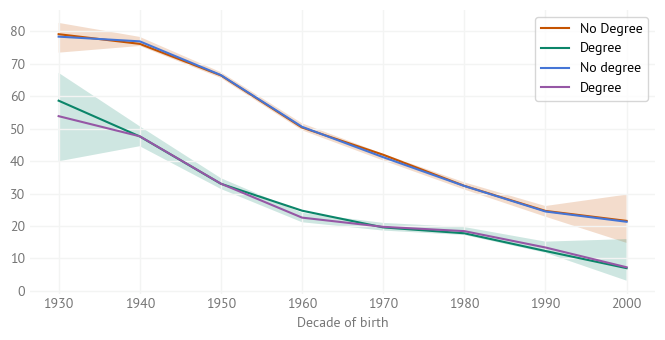

In [238]:
table.plot()
plot_table(table23)
decorate(xlabel="Decade of birth")

In [239]:
table = make_marriage_table(sample, "married33")
table33 = make_table(normalized, 'married33')

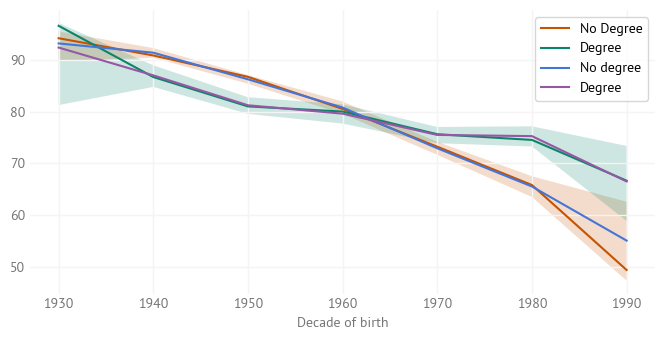

In [240]:
table.plot()
plot_table(table33)
decorate(xlabel="Decade of birth")

In [241]:
table = make_marriage_table(sample, "married43")
table43 = make_table(normalized, 'married43')

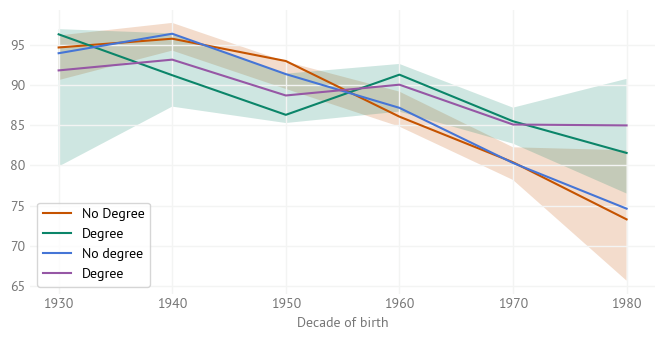

In [242]:
table.plot()
plot_table(table43)
decorate(xlabel="Decade of birth")

In [243]:
from utils import percentile_rows


def plot_marriage_tables(tables):
    table = tables[0]
    categories = table.columns
    cohorts = table.index

    for col in table.columns:
        frame = pd.DataFrame(columns=cohorts)
        for i, table in enumerate(tables):
            frame.loc[i] = table[col]

        # using the 84% CI, so non-overlapping corresponds to
        # a difference that's significant at 5% level
        low, median, high = percentile_rows(frame, [8, 50, 92])
        plt.fill_between(cohorts, low, high, alpha=0.2)
        plt.plot(cohorts, median, label=col)

In [220]:
tables23 = [
    make_marriage_table(resample_by_cycle(resp), "married23") for i in range(101)
]

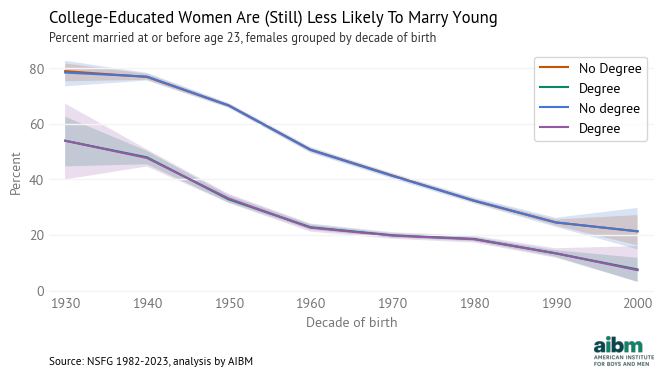

In [221]:
plot_marriage_tables(tables23)
plot_table(table23)

title = "College-Educated Women Are (Still) Less Likely To Marry Young"
subtitle = "Percent married at or before age 23, females grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

xlim = [1928, 2002]
decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 1, [inset])

In [222]:
tables33 = [
    make_marriage_table(resample_by_cycle(resp), "married33") for i in range(101)
]

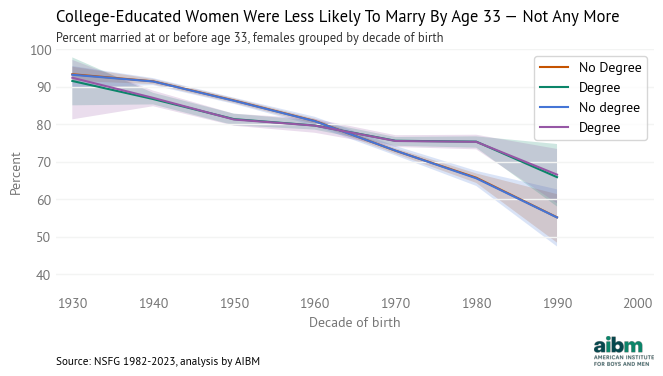

In [223]:
plot_marriage_tables(tables33)
plot_table(table33)

title = "College-Educated Women Were Less Likely To Marry By Age 33 — Not Any More"
subtitle = "Percent married at or before age 33, females grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

ylim = [35, 100]
decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim, ylim=ylim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 3, [inset])

In [224]:
tables43 = [
    make_marriage_table(resample_by_cycle(resp), "married43") for i in range(101)
]

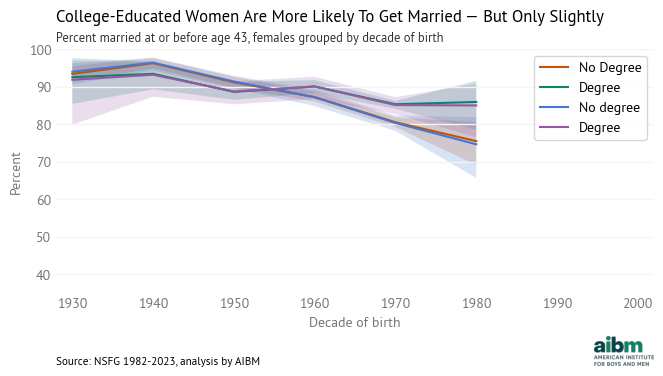

In [225]:
plot_marriage_tables(tables43)
plot_table(table43)

title = "College-Educated Women Are More Likely To Get Married — But Only Slightly"
subtitle = "Percent married at or before age 43, females grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim, ylim=ylim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 5, [inset])

## Male respondents

Load the data cleaned in `clean_nsfg.ipynb`

`anycoll` is a recode I computed, intended to indicate whether a participant attended college, regardless of whether they got a degree.

```
2002    df["anycoll"] = df["hieduc"] >= 10
2010    df["anycoll"] = df["hieduc"] >= 10
2013    df["anycoll"] = df["hieduc"] >= 10
2015    df["anycoll"] = df["hieduc"] >= 10
2017    df["anycoll"] = df["hieduc"] >= 10
2019    df["anycoll"] = df["hieduc"] >= 10
2023    df["anycoll"] = df["hieduc"] >= 5
```

Encoding in 2023

```
HIEDUC: Distribution Value n
Less than high school completion 1 623
12th grade, no diploma 2 169
GED or equivalent 3 153
High school graduate 4 807
Some college, no degree 5 956
Associate degree: occup, tech, or voc 6 353
Associate degree: academic 7 282
Bachelor's degree 8 1267
Master's degree 9 752
Professional degree 10 135
Doctoral degree 11 89
5586
```


In [244]:
resp2 = pd.read_hdf("MaleMarriageData.hdf", "MaleMarriageData")
resp2.shape

(38769, 43)

In [246]:
evrmarry = resp2["evrmarry"]
value_counts(evrmarry)

,counts
values,
False,24634
True,14135


In the 2000s cohorts, the last age where we have a decent sample is 23.

In [247]:
subset = resp2.query("birth_index==100")
value_counts(subset["ager"]).tail()

,counts
values,
19.0,221
20.0,76
21.0,83
22.0,91
23.0,80


In the 1990s cohorts, the last age where we have a decent sample is 33.

In [248]:
subset = resp2.query("birth_index==90")
value_counts(subset["ager"]).tail()

,counts
values,
29.0,170
30.0,130
31.0,150
32.0,165
33.0,101


In the 1980s cohorts, the last age where we have a decent sample is 43.

In [249]:
subset = resp2.query("birth_index==80")
value_counts(subset["ager"]).tail()

,counts
values,
39.0,202
40.0,131
41.0,135
42.0,116
43.0,83


In [250]:
add_married_column(resp2, 23)
value_counts(resp2["married23"])

,counts
values,
0.0,22730
1.0,4315
NaN,11724


In [251]:
add_married_column(resp2, 33)
value_counts(resp2["married33"])

,counts
values,
0.0,6188
1.0,8426
NaN,24155


In [252]:
add_married_column(resp2, 43)
value_counts(resp2["married43"])

,counts
values,
0.0,1032
1.0,2630
NaN,35107


In [257]:
normalized2 = normalize_weights_by_cycle(resp2)
normalized2['finalwgt'].describe()

count    38769.000000
mean         1.000000
std          1.071450
min          0.006480
25%          0.368552
50%          0.642911
75%          1.188582
max          8.789769
Name: finalwgt, dtype: float64

## Percent married by education level

In [258]:
resp2.groupby("birth_index")["anycoll"].mean()

birth_index
50     0.509317
60     0.511914
70     0.564968
80     0.518885
90     0.346049
100    0.131521
Name: anycoll, dtype: float64

In [259]:
resp2.groupby("birth_index")["bdegree"].mean()

birth_index
50     0.282609
60     0.265045
70     0.290252
80     0.227630
90     0.112909
100    0.021482
Name: bdegree, dtype: float64

In [260]:
resp2.groupby("birth_index")["evrmarry"].mean()

birth_index
50     0.695652
60     0.694424
70     0.611974
80     0.317966
90     0.087660
100    0.006576
Name: evrmarry, dtype: float64

In [261]:
table23 = make_table(normalized2, 'married23')

In [262]:
tables23 = [
    make_marriage_table(resample_by_cycle(resp2), "married23") for i in range(101)
]

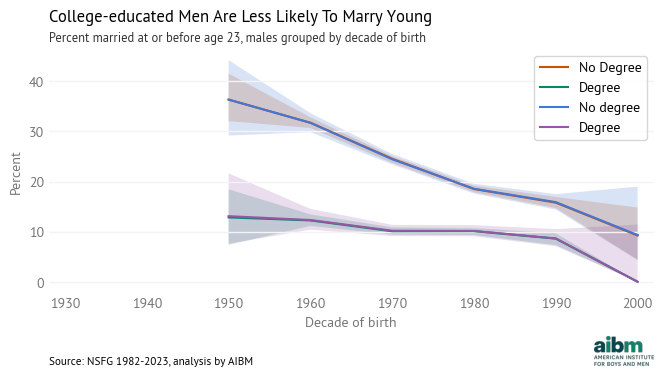

In [263]:
plot_marriage_tables(tables23)
plot_table(table23)

title = "College-educated Men Are Less Likely To Marry Young"
subtitle = "Percent married at or before age 23, males grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

xlim = [1928, 2002]
decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 2, [inset])

In [264]:
tables33 = [
    make_marriage_table(resample_by_cycle(resp2), "married33") for i in range(101)
]

In [265]:
table33 = make_table(normalized2, 'married33')

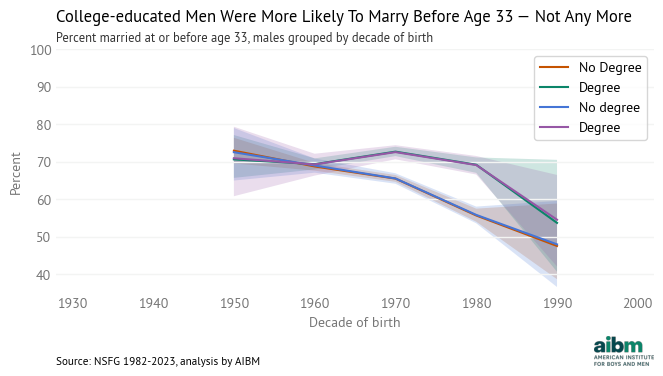

In [266]:
plot_marriage_tables(tables33)
plot_table(table33)

title = "College-educated Men Were More Likely To Marry Before Age 33 — Not Any More"
subtitle = "Percent married at or before age 33, males grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

ylim = [35, 100]
decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim, ylim=ylim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 4, [inset])

In [267]:
tables43 = [
    make_marriage_table(resample_by_cycle(resp2), "married43") for i in range(101)
]

In [268]:
table43 = make_table(normalized2, 'married43')

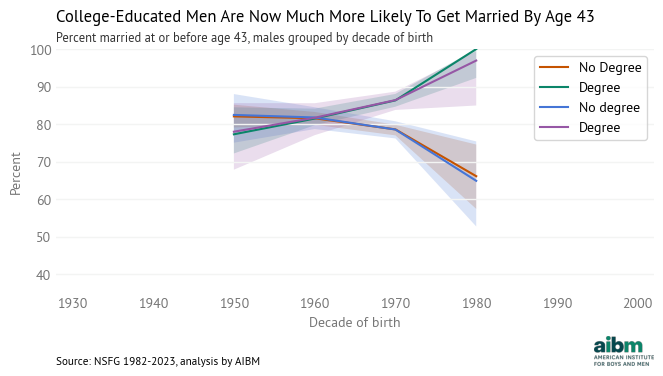

In [269]:
plot_marriage_tables(tables43)
plot_table(table43)

title = "College-Educated Men Are Now Much More Likely To Get Married By Age 43"
subtitle = "Percent married at or before age 43, males grouped by decade of birth"
add_title(title, subtitle)

subtext = """Source: NSFG 1982-2023, analysis by AIBM"""
add_subtext(subtext)

decorate(xlabel="Decade of birth", ylabel="Percent", xlim=xlim, ylim=ylim)
inset = add_aibm_logo()
savefig("nsfg_marriage", 6, [inset])